In [1]:
from configs import cfg

cfg['input_dim'] = 301 # input dimension to LSTM
cfg['hidden_dim'] = 128 # hidden dimension for LSTM
cfg['output_dim'] = 1 # output dimension of the model
cfg['layers'] = 2 # number of layers of LSTM

cfg['dropout'] = 5e-3 # dropout rate between two layers of LSTM; useful only when layers > 1; between 0 and 1
cfg['bidirectional'] = True # True or False; True means using a bidirectional LSTM
cfg['batch_size'] = 120 # batch size of input
cfg['learning_rate'] = 1e-3 # learning rate to be used
cfg['L2_penalty'] = 1e-4 # weighting constant for L2 regularization term; this is a parameter when you define optimizer
cfg['epochs'] = 25 # number of epochs for which the model is trained
cfg['embed'] = False
cfg['score_range'] = 10
cfg['set_id'] = 1

In [2]:
import numpy as np
from preprocess import *
import pandas as pd

train_path = './essay_dataset/training_set_rel3.tsv'
training_data = load_training_set(train_path, cfg['set_id'])

glove_dict = load_dict('glove.840B.300d.pkl')

In [3]:
valid_path = './essay_dataset/valid_set.tsv'
valid_label_path = './essay_dataset/valid_sample_submission_2_column.csv'
valid_data = load_validation_set(valid_path, valid_label_path, cfg['set_id'])

In [4]:
training_data = process_scores(training_data, 'domain1_score')
valid_data = process_scores(valid_data, 'domain1_score')

In [5]:
from dataloader import *
from models import *
import time

model = LSTM_Score(cfg, True)
model = model.to(torch.device(cfg['device']))

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=cfg['learning_rate'], weight_decay=cfg['L2_penalty'])

train_indices = list(range(len(training_data)))
valid_indices = list(range(len(valid_data)))

print('ready')

ready


In [6]:
model.train()

LSTM_Score(
  (embed_linear): Linear(in_features=301, out_features=301, bias=True)
  (lstm): LSTM(301, 128, num_layers=2, batch_first=True, dropout=0.005, bidirectional=True)
  (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=1, bias=True)
)

In [7]:
train_losses = []
val_losses = []
for epoch in range(cfg['epochs']):
    tloader = DataLoader(training_data, train_indices, cfg, glove_dict)
    vloader = DataLoader(valid_data, valid_indices, cfg, glove_dict)
    
    count = 0
    avg_loss = 0
    while tloader.has_next():
        train, label, lengths = tloader.get_next()
        #print(train.size())
        #print(label.size())
        #print(lengths.size())
        model.zero_grad()
        
        y = model(train, lengths)      
        
        loss = criterion(y*cfg['score_range'], label*cfg['score_range'])
        loss.backward()
        optimizer.step()

        count += 1
        avg_loss += loss.item()
        if count % 2 == 0:
            print("count = %d, loss = %.5f" %(count, avg_loss / 2))
            save_model(model, 'models/'+'s' + str(cfg['set_id']) + '_ba' +str(cfg['batch_size']) +'e' +  str(epoch + 1) + 'b' + str(count) + '.pt')
            train_losses.append(avg_loss/2)
            avg_loss = 0
        del train, label, y, loss
    
    count = 0
    avg_loss = 0
    with torch.no_grad():
        while vloader.has_next():
            train, label, lengths = vloader.get_next()
            y = model(train, lengths)
            loss = criterion(y*cfg['score_range'], label*cfg['score_range'])
            count += 1
            avg_loss += loss.item()
            del train, label, y, loss
    print('validation loss:', avg_loss / count)
    print('epoch finished:', epoch + 1)
    val_losses.append(avg_loss/count)
    

count = 2, loss = 11.35110
count = 4, loss = 6.10464
count = 6, loss = 3.40361
count = 8, loss = 2.41178
count = 10, loss = 2.52513
count = 12, loss = 1.92355
count = 14, loss = 1.54456
validation loss: 1.382217213511467
epoch finished: 1
count = 2, loss = 1.81914
count = 4, loss = 1.68716
count = 6, loss = 1.41662
count = 8, loss = 1.22427
count = 10, loss = 1.12848
count = 12, loss = 0.93126
count = 14, loss = 1.01750
validation loss: 0.6515833586454391
epoch finished: 2
count = 2, loss = 0.80402
count = 4, loss = 1.11962
count = 6, loss = 0.84331
count = 8, loss = 0.75087
count = 10, loss = 0.68265
count = 12, loss = 0.71909
count = 14, loss = 0.77032
validation loss: 0.4024878144264221
epoch finished: 3
count = 2, loss = 0.69089
count = 4, loss = 0.91534
count = 6, loss = 0.64359
count = 8, loss = 0.71230
count = 10, loss = 0.58446
count = 12, loss = 0.64254
count = 14, loss = 0.64948
validation loss: 0.40089990943670273
epoch finished: 4
count = 2, loss = 0.74140
count = 4, loss =

In [17]:
np.save('val_loss_set1.npy', val_losses)
np.save('train_loss_set1.npy', train_losses)

In [19]:
model = load_model(LSTM_Score, './models/s8_ba120e15b6.pt', cfg)
valid_indices = list(range(len(valid_data)))

In [9]:
from evaluation import QWK_score

vloader = DataLoader(valid_data, valid_indices, cfg, glove_dict)
count = 0
avg_loss = 0
MAE = 0
targets = []
preds = []
with torch.no_grad():
    while vloader.has_next():
        train, label, lenghts = vloader.get_next()
        y = model(train, lenghts)
        #y = y.permute(0, 2, 1)
        #print(label - y)
        
        loss = criterion(y*cfg['score_range'], label*cfg['score_range'])
        
        pred = np.round(y.cpu().numpy() * cfg['score_range'])
        target = np.round(label.cpu().numpy() * cfg['score_range'])

        pred = pred.flatten().astype(int)
        target = target.flatten().astype(int)
        
        targets.append(target)
        preds.append(pred)
        
        #print(targets[0])
        #print(preds[0])
        
        count += 1
        avg_loss += loss.item()
        MAE += (y-label).abs().mean().item()
        
        del train, label, y, loss
        
print('validation MSE:', avg_loss / count)
print('validation MAE:', MAE / count)
print('QWK Score:', QWK_score(np.asarray(targets).flatten(), np.asarray(preds).flatten(), min_rating = 0, max_rating = cfg['score_range']))

validation MSE: 0.48111525923013687
validation MAE: 0.054150331765413284
QWK Score: 0.8423965173762267


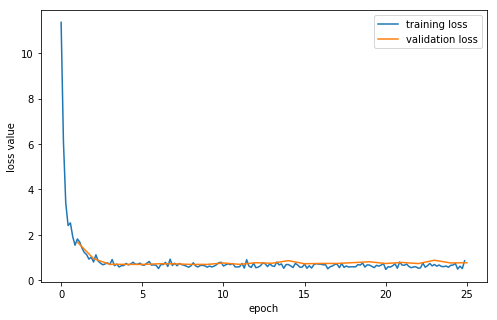

In [16]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(np.arange(len(train_losses)) / (len(train_losses) // len(val_losses)),train_losses,label='training loss')
ax.plot(np.arange(1,len(val_losses)+1) ,np.array(val_losses) + 0.3,label='validation loss')

ax.set_xlabel('epoch')
ax.set_ylabel('loss value')
ax.legend()
plt.show()

In [12]:
targets

[array([ 7,  6,  7, 10,  6,  6,  5,  5,  9,  6, 10,  8,  8,  8,  7,  8,  7,
         6,  8,  9,  7,  6,  6,  8,  6,  7,  7,  8,  9,  6,  7,  8,  8,  4,
         7,  6,  6,  7,  8,  5,  8,  9,  8,  8,  7,  5,  7,  6,  8,  7,  6,
         6,  6,  8,  7,  8,  7,  8,  5,  8,  8,  5,  7,  6,  6,  5,  4,  7,
         8,  3,  6,  6,  9,  0,  4,  7,  4,  7,  5,  7,  7,  6,  7,  9,  8,
         5,  8,  7,  4,  7,  7, 10,  6,  4,  5,  6,  6,  6,  7,  6,  7,  6,
         7,  8,  6,  9,  9,  9,  8,  7,  7,  3,  6,  3,  6,  7,  6,  8,  6,
         5]),
 array([5, 8, 5, 2, 6, 5, 7, 6, 6, 7, 8, 6, 7, 7, 6, 6, 6, 8, 8, 6, 5, 9,
        6, 8, 6, 6, 6, 8, 8, 8, 9, 5, 8, 5, 6, 5, 6, 7, 6, 6, 5, 8, 7, 6,
        5, 8, 6, 7, 6, 7, 7, 4, 8, 8, 4, 6, 7, 6, 7, 7, 8, 7, 5, 8, 6, 6,
        5, 7, 6, 6, 7, 7, 6, 7, 7, 5, 7, 7, 7, 5, 4, 6, 4, 7, 7, 7, 9, 7,
        5, 7, 6, 6, 7, 8, 6, 7, 8, 6, 6, 6, 7, 4, 6, 6, 7, 7, 8, 6, 6, 5,
        8, 6, 9, 6, 6, 7, 4, 6, 6, 8]),
 array([6, 7, 6, 7, 5, 6, 6, 8, 5, 4, 4, 6, 

In [13]:
preds

[array([7, 6, 7, 9, 6, 5, 5, 4, 8, 6, 8, 8, 7, 8, 6, 8, 7, 6, 9, 8, 6, 6,
        7, 8, 5, 7, 7, 8, 9, 6, 7, 8, 7, 4, 8, 5, 6, 7, 8, 6, 8, 8, 7, 7,
        7, 5, 7, 8, 8, 7, 6, 6, 6, 8, 7, 8, 7, 8, 5, 8, 7, 5, 7, 5, 6, 4,
        4, 7, 9, 4, 6, 7, 8, 3, 5, 7, 5, 7, 5, 7, 6, 6, 7, 8, 7, 4, 8, 6,
        5, 7, 7, 8, 5, 4, 5, 6, 6, 6, 6, 6, 6, 5, 7, 9, 6, 8, 8, 8, 7, 5,
        8, 4, 7, 4, 6, 6, 5, 9, 7, 5]),
 array([5, 9, 5, 4, 5, 6, 8, 6, 5, 6, 8, 6, 7, 7, 7, 6, 6, 7, 7, 6, 5, 8,
        6, 9, 7, 6, 6, 8, 8, 7, 9, 6, 8, 6, 5, 5, 6, 7, 6, 6, 6, 9, 7, 6,
        5, 9, 7, 8, 7, 8, 6, 5, 8, 8, 5, 7, 8, 7, 8, 7, 7, 8, 5, 8, 6, 6,
        5, 8, 7, 7, 7, 7, 6, 8, 7, 5, 8, 7, 7, 4, 4, 7, 6, 8, 7, 8, 8, 7,
        5, 7, 5, 5, 6, 9, 6, 7, 8, 6, 6, 5, 7, 5, 6, 5, 7, 7, 7, 6, 6, 5,
        9, 5, 8, 5, 6, 7, 4, 6, 5, 8]),
 array([5, 8, 5, 7, 5, 5, 6, 8, 5, 4, 4, 6, 9, 9, 6, 7, 8, 5, 8, 9, 6, 9,
        7, 5, 6, 7, 8, 5, 7, 8, 7, 8, 9, 6, 7, 8, 8, 9, 6, 8, 7, 4, 7, 5,
        6, 6, 4, 6, 8, 8, 7, 8, 

In [18]:
train_losses

[11.351104974746704,
 6.104636788368225,
 3.4036093950271606,
 2.4117778539657593,
 2.525133728981018,
 1.9235459566116333,
 1.5445597767829895,
 1.8191364407539368,
 1.687156081199646,
 1.4166203737258911,
 1.224267601966858,
 1.1284845173358917,
 0.9312625527381897,
 1.0175018608570099,
 0.8040228188037872,
 1.1196208596229553,
 0.8433053195476532,
 0.7508737444877625,
 0.6826477944850922,
 0.7190851271152496,
 0.7703181505203247,
 0.6908883154392242,
 0.915344774723053,
 0.643592894077301,
 0.7123017311096191,
 0.5844634473323822,
 0.6425448656082153,
 0.6494772434234619,
 0.7414007782936096,
 0.6765156090259552,
 0.7147599458694458,
 0.7944070398807526,
 0.7060414552688599,
 0.7045169770717621,
 0.755422443151474,
 0.6705136597156525,
 0.6681559085845947,
 0.7553592324256897,
 0.8287351429462433,
 0.6655273139476776,
 0.6800683736801147,
 0.6566336750984192,
 0.5160068273544312,
 0.6954564154148102,
 0.6886806488037109,
 0.790027529001236,
 0.609412431716919,
 0.9287274181842804,
 

In [19]:
val_losses

[1.382217213511467,
 0.6515833586454391,
 0.4024878144264221,
 0.40089990943670273,
 0.3977401405572891,
 0.4257807284593582,
 0.4249246343970299,
 0.39795295149087906,
 0.3990744575858116,
 0.4607278034090996,
 0.4000275880098343,
 0.47164236754179,
 0.45067597180604935,
 0.564243882894516,
 0.42687104642391205,
 0.44147878885269165,
 0.44043538719415665,
 0.4769660159945488,
 0.5146990641951561,
 0.43800487369298935,
 0.48465248197317123,
 0.43477147072553635,
 0.5825341492891312,
 0.46248809248209,
 0.4727556183934212]